In [2]:
import pandas as p
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sklearn.svm as svm
from sklearn.model_selection import train_test_split

In [3]:
#Read dataset
data = p.read_csv('segment.dat', delimiter=" ", header=None,
                 names = ["rcc","rcr","rpc","sld5","sld2","vem","ves","hem",
                         "hes","im","rrm","rbm","rgm","erm","ebm","egm",
                         "vam","sam","hum","Y"])
print(data.head())
np.shape(data)

     rcc    rcr  rpc      sld5  sld2       vem       ves       hem       hes  \
0  218.0  178.0    9  0.111111   0.0  0.833333  0.547722  1.111109  0.544331   
1  113.0  130.0    9  0.000000   0.0  0.277778  0.250924  0.333333  0.365148   
2  202.0   41.0    9  0.000000   0.0  0.944448  0.772202  1.111112  1.025597   
3   32.0  173.0    9  0.000000   0.0  1.722222  1.781593  9.000000  6.749488   
4   61.0  197.0    9  0.000000   0.0  1.444444  1.515353  2.611111  1.925463   

           im         rrm         rbm         rgm        erm       ebm  \
0   59.629630   52.444443   75.222220   51.222220 -21.555555  46.77778   
1    0.888889    0.000000    2.555556    0.111111  -2.666667   5.00000   
2  123.037040  111.888885  139.777790  117.444440 -33.444443  50.22222   
3   43.592594   39.555557   52.888890   38.333336 -12.111111  27.88889   
4   49.592594   44.222220   61.555557   43.000000 -16.111110  35.88889   

         egm         vam       sam       hum  Y  
0 -25.222221   75.222220

(2310, 20)

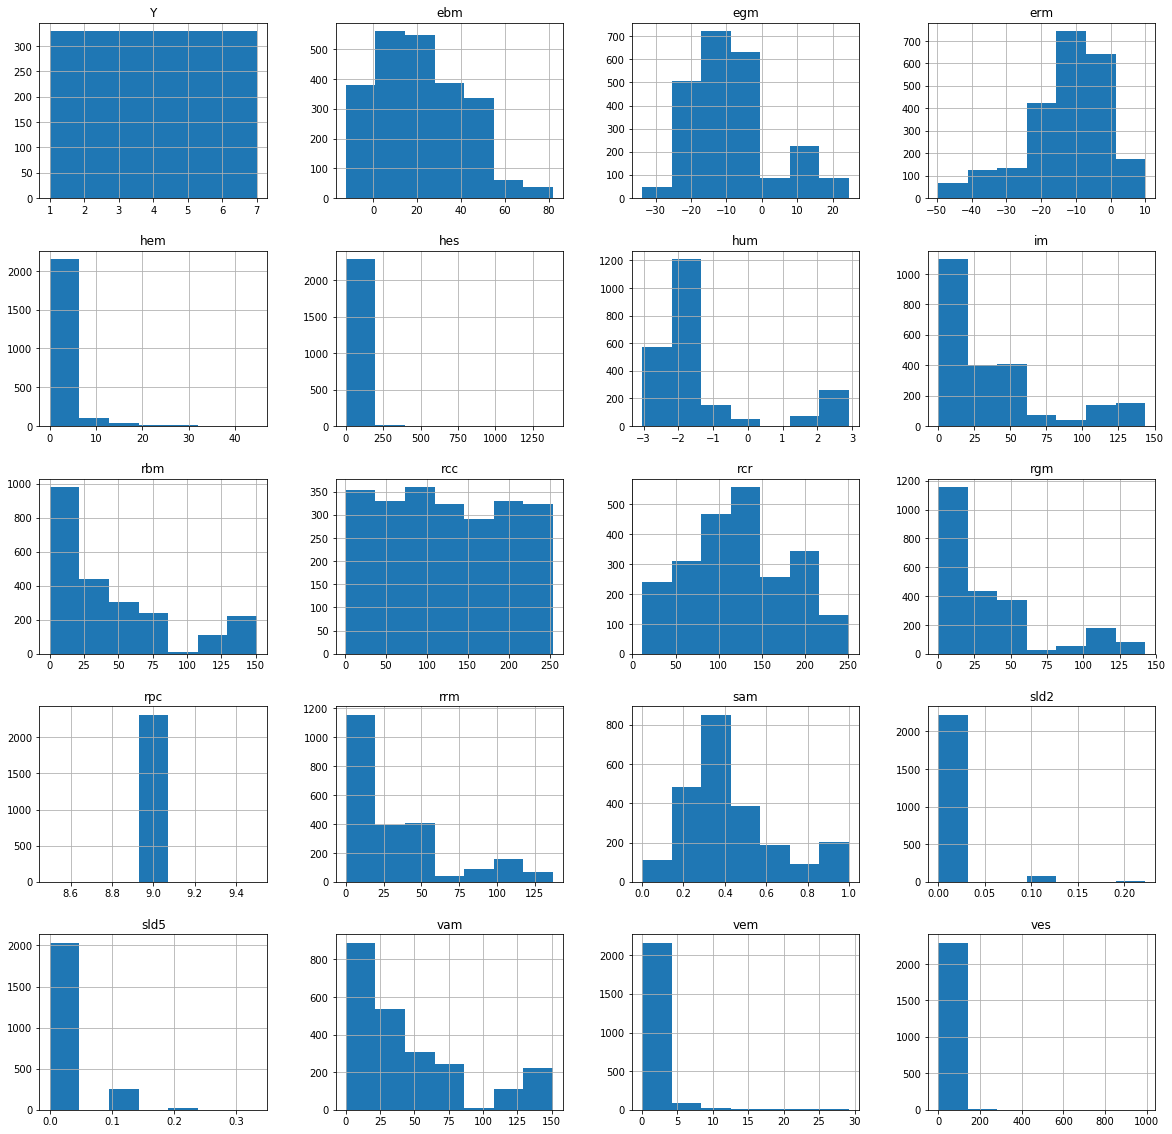

In [4]:
#Plot histogram
hist = data.hist(figsize=(20,20),bins=7)

/home/jaime/Documents/pyenv/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=9.0, right=9.0
  ax.set_xlim(boundaries_list[j])
/home/jaime/Documents/pyenv/lib/python3.7/site-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=9.0, top=9.0
  ax.set_ylim(boundaries_list[i])
/home/jaime/Documents/pyenv/lib/python3.7/site-packages/pandas/plotting/_misc.py:100: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=9.0, right=9.0
  ax.set_xlim(boundaries_list[i])


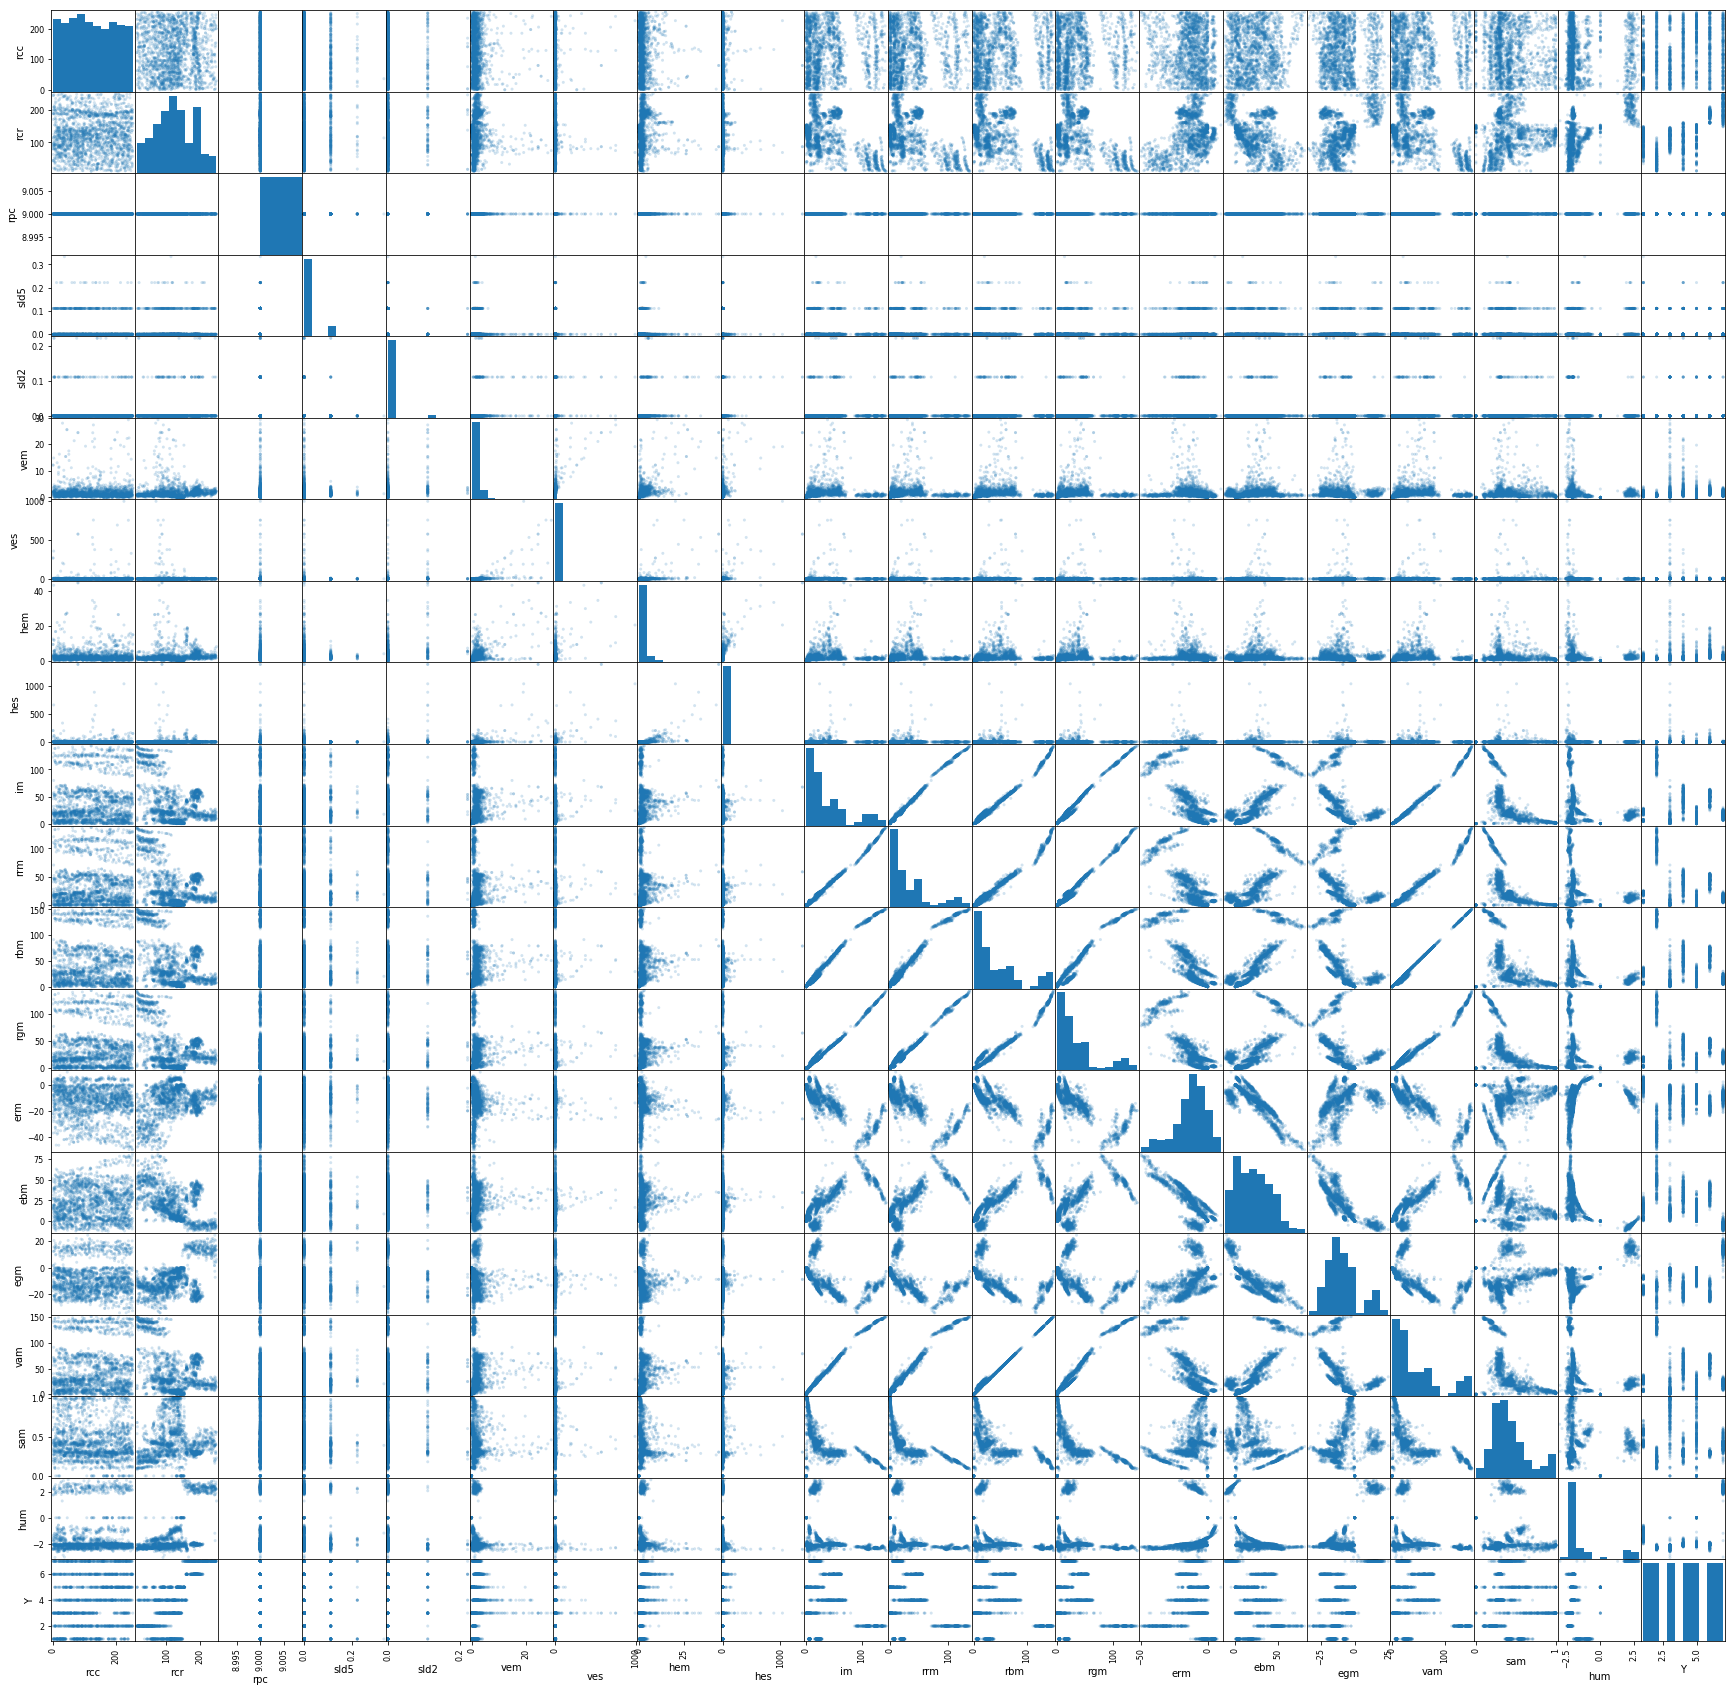

In [29]:
scatter_mat = p.plotting.scatter_matrix(data,alpha=0.2, figsize=(30, 30))

In [7]:
#PROCESS DATASET
X = data.loc[:,'rcc':'hum']
X = np.array(X.drop(labels=['egm','erm','vam','im','rpc','sld5','sld2','hes','ves','vem','hem'],axis=1))
X = normalize_matrix(X)

y = np.array(data["Y"])
y_dummy = np.array(p.get_dummies(y))
print(np.shape(X))

(2310, 8)


In [6]:
#FUNCTIONS
#Sigmoid function
sigmoid_function = lambda a : 1 / (1 + np.vectorize(np.exp)(-a))

#Gradient function
def gradient(theta,x_T,y_T,m):
    gradient = 1/m * x_T @ (sigmoid_function(theta @ x_T).T - y_T)
    return (np.asarray(gradient).ravel())

#Cost function
def cost_function(theta,x_T,y_T,m):
    cost = -1/m * ((np.log(sigmoid_function(theta @ x_T)) @ y_T) + (np.log(1 - sigmoid_function(theta @ x_T)) @ (1 - y_T)))
    return (np.asarray(cost).ravel()[0])

#Regularized Gradient function
def regularized_gradient(theta,x_T,y_T,m,l):
    theta = np.matrix(theta)
    regularization = (l/m) * theta.T
    regularization[0] = 0
    gradient = 1/m * x_T @ (sigmoid_function(theta @ x_T).T - y_T) + regularization
    return (np.asarray(gradient).ravel())

#Regularized Cost function
def regularized_cost_function(theta,x_T,y_T,m,l):
    regularization =  (l/(2*m)) * (theta @ theta.T)
    cost = (-1/m * ((np.log(sigmoid_function(theta @ x_T)) @ y_T) + (np.log(1 - sigmoid_function(theta @ x_T)) @ (1 - y_T)))) + regularization
    return (np.asarray(cost).ravel()[0])

#Classic OneVSAll
def oneVsAll(x,y,num_etiquetas,reg):
    m = x.shape[0]
    theta = np.zeros(x.shape[1])
    labels = (np.ones((np.shape(y)[0],num_etiquetas)) * np.array(y))
    r = range(1,num_etiquetas + 1)
    labels = labels == r
    labels = labels * 1
    labels = np.matrix(labels)

    theta_opt = []

    for i in range(0,num_etiquetas):
        optimizer = opt.minimize(regularized_cost_function,x0=theta,args=(x.T,labels[:,i],m,reg),method='L-BFGS-B',jac=regularized_gradient)
        theta_opt.append(optimizer['x'])
  
    theta_opt = np.asarray(theta_opt)
    return theta_opt

#SVN OneVSAll
def oneVsAllSVN(c,kernel,gamma,X,y):

    predictors = []

    if kernel == 'rbf':
        for i in np.arange(0,np.shape(y)[1]):
            svm_model = svm.SVC(kernel = 'rbf',probability=True, C = c, gamma=gamma)
            classifier = svm_model.fit(X,y[:,i])
            predictors.append(classifier)
            
    if kernel == 'linear':    
        for i in np.arange(0,np.shape(y)[1]):
            svm_model = svm.SVC(kernel = 'linear',probability=True, C = c)
            classifier = svm_model.fit(X,y[:,i])
            predictors.append(classifier)
        
    return predictors

def normalize_matrix(x): 
    #Calculations per column
    mean = np.mean(x,0)
    std = np.std(x,0)

    x = np.subtract(x, np.matrix(mean))
    x = np.true_divide(x, np.matrix(std))
    
    return x


Adjust n:  0.15000000000000002


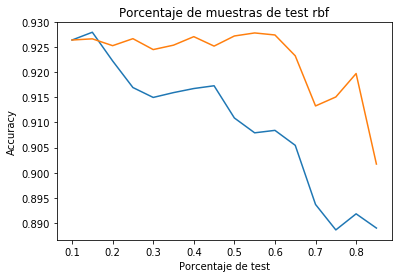

C adjusted:  81


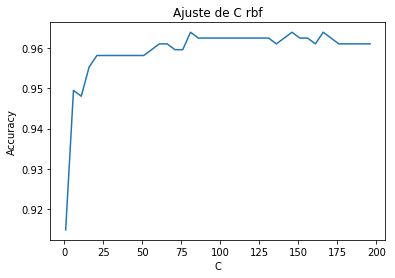

Sigma adjusted:  0.7000000000000001


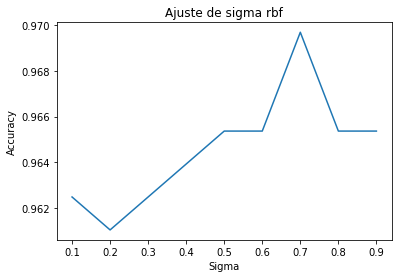

Final accuracy:  0.974207492795389
Adjust n:  0.15000000000000002


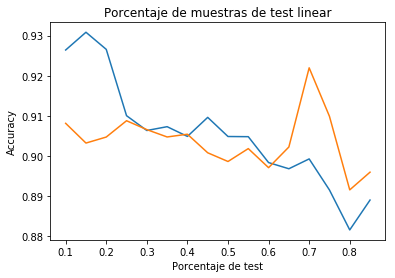

C adjusted:  51


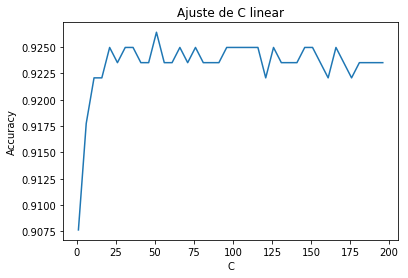

Final accuracy:  0.9181556195965417


In [14]:
#MULTICLASS SVN VERSION
def SVN_multiclass_analysis(c,kernel,gamma,Xtrain,ytrain_dummy,Xtest,ytest):
    predictors = oneVsAllSVN(c,kernel,gamma,Xtrain,ytrain_dummy)
    results = []
    for p in predictors:
        results.append(p.predict_proba(Xtest)[:,1])
    
    results = np.argmax(results,0) + 1
    return np.sum(results == ytest)/np.shape(ytest)[0]

def test_SVN(kernel):
    #Adjust n
    N = np.arange(0.1,0.9,0.05)
    res1 = []
    res2 = []
    finals = 0
    
    for n in N:
        Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=n,random_state=0)
        ytrain_dummy = np.array(p.get_dummies(ytrain))
        res1.append(SVN_multiclass_analysis(1.0,kernel,0.1, Xtrain,ytrain_dummy,Xtest,ytest))
        res2.append(SVN_multiclass_analysis(1.0,kernel,0.1, Xtrain,ytrain_dummy,Xtrain,ytrain))
    print('Adjust n: ',N[np.argmax(res1)])
    plt.title('Porcentaje de muestras de test ' + kernel)
    plt.xlabel('Porcentaje de test')
    plt.ylabel('Accuracy')
    plt.plot(N,res1,'-')
    plt.plot(N,res2,'-')
    plt.show()

    finaln = N[np.argmax(res1)]
    Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=0)
    ytrain_dummy = np.array(p.get_dummies(ytrain))

    #Adjust C
    C = range(1,200,5)
    res1 = []
    for c in C:
        res1.append(SVN_multiclass_analysis(c,kernel,0.1, Xtrain,ytrain_dummy,Xtest,ytest))

    print('C adjusted: ',C[np.argmax(res1)])
    plt.title('Ajuste de C ' + kernel)
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.plot(C,res1,'-')
    plt.show()

    finalc = C[np.argmax(res1)]

    #Adjust sigma
    if kernel == 'rbf':
        sigma = np.arange(0.1,1.0,0.1)
        res1 = []
        for s in sigma:
            res1.append(SVN_multiclass_analysis(finalc,kernel,s, Xtrain,ytrain_dummy,Xtest,ytest))

        print('Sigma adjusted: ',sigma[np.argmax(res1)])
        plt.title('Ajuste de sigma ' + kernel)
        plt.xlabel('Sigma')
        plt.ylabel('Accuracy')
        plt.plot(sigma,res1,'-')
        plt.show()

        finals = sigma[np.argmax(res1)]

    #Measure accuracy mean
    res1 = []
    for i in range(0,20):
        Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=finaln)
        ytrain_dummy = np.array(p.get_dummies(ytrain))
        res1.append(SVN_multiclass_analysis(finalc,kernel,finals, Xtrain,ytrain_dummy,Xtest,ytest))

    print('Final accuracy: ', np.mean(res1))
    
test_SVN('rbf')
test_SVN('linear')

/home/jaime/Documents/pyenv/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/home/jaime/Documents/pyenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: overflow encountered in exp
  outputs = ufunc(*inputs)
/home/jaime/Documents/pyenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/home/jaime/Documents/pyenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2002: RuntimeWarning: overflow encountered in exp
  outputs = func(*inputs)


Adjust n:  0.15000000000000002


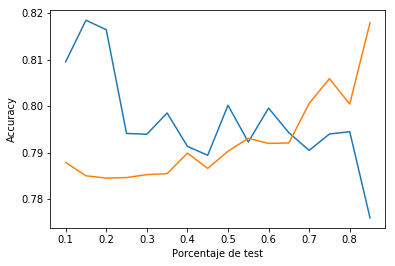

L adjusted:  1.0


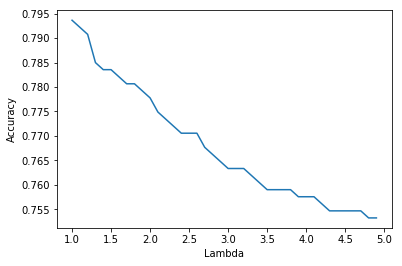

Final accuracy:  0.7917867435158501


In [11]:
#Multiclass Classic Version
def classic_multiclass_analysis(l,classes,X,y,Xtest,ytest):
    y = np.matrix(y)
    X = np.matrix(X)
    m = Xtest.shape[0]

    theta_opt = oneVsAll(X,y.T,classes,l)
    sigmoid_results = sigmoid_function(theta_opt @ Xtest.T).T
    sigmoid_results = np.argmax(sigmoid_results,1) + 1

    comparition_array = sigmoid_results.T == ytest
    result = np.sum(comparition_array)/m
    return result

def test_LR():
    #Adjust n
    N = np.arange(0.1,0.9,0.05)
    res1 = []
    res2 = []
    
    for n in N:
        Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=n,random_state=0)
        ytrain_dummy = np.array(p.get_dummies(ytrain))
        res1.append(classic_multiclass_analysis(0,7,Xtrain,ytrain,Xtest,ytest))
        res2.append(classic_multiclass_analysis(0,7,Xtrain,ytrain,Xtrain,ytrain))
    print('Adjust n: ',N[np.argmax(res1)])
    plt.xlabel('Porcentaje de test')
    plt.ylabel('Accuracy')
    plt.plot(N,res1,'-')
    plt.plot(N,res2,'-')
    plt.show()

    finaln = N[np.argmax(res1)]
    Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=0)
    ytrain_dummy = np.array(p.get_dummies(ytrain))

    #Adjust lambda
    L = np.arange(1,5,0.1)
    res1 = []
    for l in L:
        res1.append(classic_multiclass_analysis(l,7,Xtrain,ytrain,Xtest,ytest))

    print('L adjusted: ',L[np.argmax(res1)])
    plt.xlabel('Lambda')
    plt.ylabel('Accuracy')
    plt.plot(L,res1,'-')
    plt.show()

    finall = L[np.argmax(res1)]
    
    #Measure accuracy mean
    res1 = []
    for i in range(0,20):
        Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=finaln)
        ytrain_dummy = np.array(p.get_dummies(ytrain))
        res1.append(classic_multiclass_analysis(finall,7,Xtrain,ytrain,Xtest,ytest))

    print('Final accuracy: ', np.mean(res1))
    
test_LR()

In [17]:
#SVC MULTICLASS SKLEARN 
res = []
for i in range(0,40):
    Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.15)
    svm_model = svm.SVC(kernel = 'rbf', gamma=0.7, C = 81)
    classifier = svm_model.fit(Xtrain,ytrain)
    res.append(np.sum(classifier.predict(Xtest) == ytest)/np.shape(ytest)[0])
print(np.mean(res))

0.977377521613833


In [14]:
#NEURAL NETS FUNCTIONS

sigmoid_function = lambda a : 1 / (1 + np.vectorize(np.exp)(-a))

def backprop_cost(param_nn,ninputs,nhidden,nlabels,x,y,l):
    theta1 = np.reshape(param_nn[:nhidden*(ninputs + 1)] ,(nhidden, (ninputs + 1)))
    theta2 = np.reshape(param_nn[nhidden*(ninputs + 1):] ,(nlabels, (nhidden + 1)))
    m = len(y)
    
    x = np.hstack((np.ones((m,1)),x))
    a2 = sigmoid_function(x @ theta1.T)
    a2 = np.hstack((np.ones((m,1)),a2))
    a3 = sigmoid_function(a2 @ theta2.T)
    
    y_dummy = np.matrix(p.get_dummies(y))
    
    reg = (l/(2*m)) * (np.sum(np.sum(np.power(theta1[:,1:],2),1),0) + np.sum(np.sum(np.power(theta2[:,1:],2),1),0))
    cost = (1/m * np.sum((np.diag((-1 * y_dummy) @ np.log(a3).T) - np.diag((1 - y_dummy) @ np.log(1 - a3).T)))) + reg
    
    #Si vamos a usar la funcion de check gradient necesitamos comentar backpropagation
    return cost#, backpropagation_grad(param_nn, ninputs, nhidden , nlabels , x, y, l)

def gradient_derivative(z):
    return np.multiply(sigmoid_function(z),(1 - sigmoid_function(z)))

def random_weights(L_in, L_out):
    return np.random.uniform(-0.12,0.12,(L_out,1 + L_in))

def backpropagation_grad(param_nn, ninputs, nhidden , nlabels , x, y, reg):

    theta1 = np.reshape(param_nn[:nhidden*(ninputs + 1)] ,(nhidden, (ninputs + 1)))
    theta2 = np.reshape(param_nn[nhidden*(ninputs + 1):] ,(nlabels, (nhidden + 1)))
    m = len(y)
    gradient_1 = 0
    gradient_2 = 0
    y = np.array(p.get_dummies(y))
    
    #Si vamos a usar la funcion de check gradient, comentamos esta linea
    x = np.hstack((np.ones((m,1)),x))

    for i in np.arange(m):
        
        z2 = x[i,np.newaxis]@theta1.T
        z2 = np.ravel(z2)
        z3 = np.hstack((np.ones(1), sigmoid_function(z2)))@theta2.T
        a3 = sigmoid_function(z3)  
        
        d3 = a3 - y[i,:]

        z2 = np.hstack((np.ones(1),z2))
        d2 = (d3 @ theta2) * gradient_derivative(z2)
        
        
        gradient_1 = gradient_1 + (np.matrix(d2[1:]).T @ x[i,np.newaxis])
        gradient_2 = gradient_2 + d3[np.newaxis,:].T @ np.hstack((np.ones(1), sigmoid_function(z2[1:])))[np.newaxis,:]
    
    gradient_1 /= m
    gradient_2 /= m
    
    gradient_1[:,1:] += theta1[:,1:] * (reg/m) 
    gradient_2[:,1:] += theta2[:,1:] * (reg/m) 

    return np.hstack((np.ravel(gradient_1), np.ravel(gradient_2)))

Layers adjusted:  12


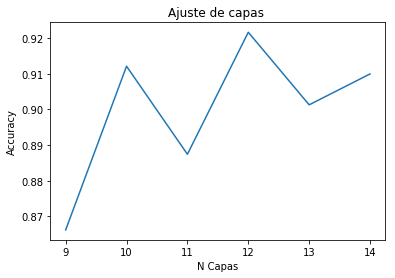

Accuracy:  0.9216450216450216


In [25]:
#NEURAL NETS

def NeuralNet_analysis(x, y, hiddensize,l, iters):
    #Set the main parameters
    inputsize = 8
    labels = 7
    m = len(y)

    #Get theta
    theta1 = random_weights(inputsize,hiddensize)
    theta2 = random_weights(hiddensize,labels)
    nn_params = np.hstack((theta1.ravel(),theta2.ravel()))

    #Minimize theta
    res = opt.minimize(backprop_cost,x0=nn_params,args=(inputsize,hiddensize,labels,x,y,l),method='TNC',options={'maxiter': iters},jac=backpropagation_grad)
    theta1 = np.reshape(res['x'][:hiddensize*(inputsize + 1)] ,(hiddensize, (inputsize + 1)))
    theta2 = np.reshape(res['x'][hiddensize*(inputsize + 1):] ,(labels, (hiddensize + 1)))

    #Forward propagation
    x = np.hstack((np.ones((np.shape(x)[0],1)),x))
    a2 = sigmoid_function(x @ theta1.T)
    a2 = np.hstack((np.ones((m,1)),a2))
    a3 = sigmoid_function(a2 @ theta2.T)

    #Get accuracy
    return np.sum(np.ravel(np.argmax(a3, axis = 1) + 1) == data['Y'].T)/m

#Hidden layer configuration
LAY = range(9,15)
res1 = []
for lay in LAY:
    res1.append(NeuralNet_analysis(X,y,lay,1, 70))
print('Layers adjusted: ',LAY[np.argmax(res1)])
plt.title('Ajuste de capas ')
plt.xlabel('N Capas')
plt.ylabel('Accuracy')
plt.plot(LAY,res1,'-')
plt.show()

print('Accuracy: ',np.max(res1))

Iterations adjusted:  90


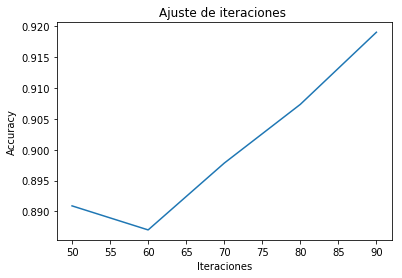

Accuracy:  0.919047619047619


In [26]:
#Iterations configuration
I = range(50,100,10)
res1 = []
for i in I:
    res1.append(NeuralNet_analysis(X,y,lay,1, i))
print('Iterations adjusted: ',I[np.argmax(res1)])
plt.title('Ajuste de iteraciones ')
plt.xlabel('Iteraciones')
plt.ylabel('Accuracy')
plt.plot(I,res1,'-')
plt.show()

print('Accuracy: ',np.max(res1))